[View in Colaboratory](https://colab.research.google.com/github/zabiullakhangithub/Image_Classification_Project_2/blob/master/Image_Classification_Project_2.ipynb)

**Image Classification Project** In this project, you'll classify images from the CIFAR-10 dataset



#Step:1 Downloading data from source




In [2]:
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import tarfile

    
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import random

ModuleNotFoundError: ignored

In [0]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [0]:
class DLProgress(tqdm):
  last_block = 0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total = total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num

In [0]:
if not isfile('cifar-10-python.tar.gz'):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
                
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

# Step:2 Data Visualization

In [0]:
#function to unpickle images & label_names
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
#get label names from batches.meta file
label_names = unpickle("{}/batches.meta".format(cifar10_dataset_folder_path))
label_name_array=label_names[b'label_names']

In [0]:

#get images and label index from batch files#get ima 
batch_num = 5 ## values 1 to 5 only
data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))

data = data_label[b'data']
imgs=np.asanyarray(data).astype("uint8")

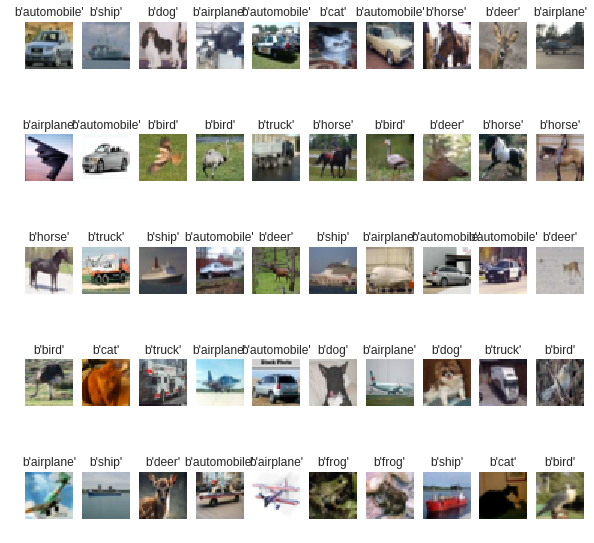

In [153]:
columns = 10
rows = 5
fig=plt.figure(figsize=(10, 10))

for i in range(1, columns*rows +1):
    num = random.randint(0,10000)
    one_img=imgs[num,:]
    img=one_img.reshape(3,32,32).transpose([1, 2, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    fig.gca().grid(False)
    plt.title(label_name_array[int(data_label[b'labels'][num])])

# Step:3 Data Preprocessing & Saving

In [0]:
## Function to normalize image data## Funct 
## This is to convert RGB image to gray scale image of range 0 to 1
def normalize(x):
  return x/255  ## min value is 0 & max value is 255 for RGB

In [0]:
## Function for one-hot encoding 
def one_hot_encoding(x):
  return np.asarray(pd.get_dummies(x))

In [0]:
## Function to load batch from data set
def load_cifar10_batch(cifar10_dataset_folder_path,batch_num):
  data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))
  #print(data_label)
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

## Function to load test data from data set
def load_cifar10_test(cifar10_dataset_folder_path):
  data_label = unpickle("{}/test_batch".format(cifar10_dataset_folder_path))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

In [0]:
## Function to normalize features and perform one_hot_encoding on labels
def _preprocess_and_save(normalize,one_hot_encoding,features,labels,filename):
  features = normalize(features)
  labels = one_hot_encoding(labels)
  pickle.dump((features,labels),open(filename,'wb'))

In [0]:
## Function to preprocess,split and save Traing, Validation & Test Data
def preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding):
  
  num_batches = 5
  valid_features = []
  valid_labels = []
  
  for i in range (1,num_batches+1):
    
    # Load Data from batches
    features,labels = load_cifar10_batch(cifar10_dataset_folder_path,i)
    valid_count = int(len(features)*0.1)
    
    #print(features[:-valid_count])
    #To Save Traing Data
    _preprocess_and_save(normalize,one_hot_encoding,features[:-valid_count],labels[:-valid_count],"preprocess_batch_{}.p".format(i)) 
    
    # Validation Data from batch
    valid_features.extend(features[-valid_count:])
    valid_labels.extend(labels[-valid_count:])
  
  # To Save Validation Data
  _preprocess_and_save(normalize,one_hot_encoding,np.asarray(valid_features),np.asarray(valid_labels),"preprocess_validation.p".format(i))
  
  
  # To Save Test Data 
  
  features_test,labels_test = load_cifar10_test(cifar10_dataset_folder_path)
  _preprocess_and_save(normalize,one_hot_encoding,features_test,labels_test,"preprocess_test.p".format(i))

In [0]:
## Preprocess and save Train, Validation & Test Data
preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding)

In [160]:

!ls

cifar-10-batches-py	preprocess_batch_2.p  preprocess_test.p
cifar-10-python.tar.gz	preprocess_batch_3.p  preprocess_validation.p
datalab			preprocess_batch_4.p
preprocess_batch_1.p	preprocess_batch_5.p


# Step:4 Implementing Input Methods

In [0]:
## Function to return batch of Image Input
def neural_net_image_input(image_shape):
  return tf.placeholder(tf.float32,shape=(None,)+image_shape,name='x')

In [0]:
## Function to return batch of Label Input
def neural_net_label_input(n_classes):
  return tf.placeholder(tf.float32,shape=(None,n_classes),name='y')

In [0]:
## Function to return keep probability for drop outs## Funct 
def neural_net_keep_prob_input():
  return tf.placeholder(tf.float32,name='keep_prob')

# Step:5 Implementing Convolution and Max Pooling Layer

In [0]:
## This is to build Convolution and Max Pooling Layer
#x_tensor: input
#conv_num_outputs: Number of output from convolution layer
#conv_ksize : convolutional layer kernal size
#conv_strides : convolutionallayer Sride
#pool_ksize: max-pooling kernal size
#pool_strides: max-pooling srides 
#


def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
  
  ## To Caluculate weights and bias
  weights = tf.Variable(tf.truncated_normal([*conv_ksize,x_tensor.shape.as_list()[3],conv_num_outputs],stddev=5e-2))
  bias = tf.Variable(tf.zeros(conv_num_outputs))
  
  ## Convolution layer
  
  conv_layer = tf.nn.conv2d(x_tensor,weights,strides=[1,*conv_strides,1],padding='SAME')
  
  ## Add bias
  
  conv_layer = tf.nn.bias_add(conv_layer,bias)
  
  
  ## Add activation function
  
  conv_layer = tf.nn.relu(conv_layer)
  
  
  ## Add max-pooling 
  
  conv_layer = tf.nn.max_pool(conv_layer,ksize=[1,*pool_ksize,1],strides=[1,*pool_strides,1],padding='SAME')
  
  return conv_layer

# Step:6 Implementing Flatten Layer

In [0]:
def flatten(x_tensor):
  return tf.contrib.layers.flatten(x_tensor) ## Using tensorflow flatten function

# Step:7 Implementing Fully Connected Layer


In [0]:
def fully_conn(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

# Step:8 Implementing Output Layer


In [0]:
def output(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

# Step:9 Implementing Convolution Network


In [0]:
def conv_net(x,keep_prob):
  
  # Apply 3 convolutional layers
  
  #print(x)
  #print(keep_prob)
  ## Convolution Layer-1
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #print(x)
  x = tf.layers.dropout(x,rate=0.4)
  
  ## Convolution Layer-2
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=0.4)
  
  ## Convolution Layer-3
  #x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #x = tf.layers.dropout(x,rate=keep_prob)
  
  
  # Apply Flatten Layer
  x = flatten(x)
  
  
  
  # Apply 3 Fully Connected Layers
  
  #x = fully_conn(x,768)
  x = fully_conn(x,384)
  x = fully_conn(x,192)
  #x = fully_conn(x,86)
  #x = fully_conn(x,43)
  
  
  # Apply output Layer
  
  x = output(x,10)
  
  return x

# Step 10: Implement Tensorflow Neural Network


In [0]:
tf.reset_default_graph()

In [0]:
#Inputs
x = neural_net_image_input((32,32,3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()
#print(x)

In [0]:
logits = conv_net(x,keep_prob)

In [0]:
logits = tf.identity(logits,name="logits")

In [0]:
## Loss and Optimizer 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(cost)

In [0]:
## Accuracy
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

# Step:11 Train Network

In [0]:
def train_network(session,optimizer,keep_probability,feature_batch,label_batch):
  session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})

In [0]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [0]:
def print_status(session,feature_batch,label_batch,cost,accuracy):
  
  #Calculate Loss
  loss = session.run(cost,feed_dict={x:feature_batch,y:label_batch,keep_prob:1.0})
  #Calculate accuracy
  valid_acc = session.run(accuracy,feed_dict={x:valid_features,y:valid_labels,keep_prob:1.0})
  # Print
  print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))

# Hyperparameters

In [0]:
epochs = 100
batch_size = 256
keep_probability = 0.75

In [0]:
## Function to split and return data into batches## Functi 
def batch_features_labels(features, labels, batch_size):
     for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [0]:
## Function to load preprocess_training_batch
def load_preprocess_train_batch(batch_id,batch_size):
  filename = "preprocess_batch_{}.p".format(batch_id)
  #print(filename)
  features,labels = pickle.load(open(filename,'rb'))
  #print(features)
  return batch_features_labels(features, labels, batch_size)

# Test train model on Single Batch

In [181]:
## Test run on Batch-1 
print("Testing batch-1")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        #print(epoch)
        batch_i = 1
        #print("-->",load_preprocess_train_batch(batch_i, batch_size).size())
        for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):
            #print(batch_labels)
            train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_status(sess, batch_features, batch_labels, cost, accuracy)

Testing batch-1
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9286 Validation Accuracy: 0.341600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6639 Validation Accuracy: 0.420000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4603 Validation Accuracy: 0.448400
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.2222 Validation Accuracy: 0.476200
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.0283 Validation Accuracy: 0.485000
Epoch  6, CIFAR-10 Batch 1:  Loss:     0.8636 Validation Accuracy: 0.491600
Epoch  7, CIFAR-10 Batch 1:  Loss:     0.6984 Validation Accuracy: 0.535600
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.5852 Validation Accuracy: 0.548200
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.4865 Validation Accuracy: 0.544800
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.4451 Validation Accuracy: 0.568200
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.3849 Validation Accuracy: 0.564200
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.2722 Validation Accuracy: 0.559800
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.2537 Validation Accuracy: 0.539

Loss:     0.0432 Validation Accuracy: 0.542200
Epoch 37, CIFAR-10 Batch 1:  Loss:     0.0362 Validation Accuracy: 0.540600
Epoch 38, CIFAR-10 Batch 1:  Loss:     0.0185 Validation Accuracy: 0.525400
Epoch 39, CIFAR-10 Batch 1:  Loss:     0.0128 Validation Accuracy: 0.531800
Epoch 40, CIFAR-10 Batch 1:  Loss:     0.0211 Validation Accuracy: 0.535800
Epoch 41, CIFAR-10 Batch 1:  Loss:     0.0170 Validation Accuracy: 0.528000
Epoch 42, CIFAR-10 Batch 1:  Loss:     0.0112 Validation Accuracy: 0.516600
Epoch 43, CIFAR-10 Batch 1:  Loss:     0.0204 Validation Accuracy: 0.534200
Epoch 44, CIFAR-10 Batch 1:  Loss:     0.0208 Validation Accuracy: 0.550200
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0258 Validation Accuracy: 0.523800
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0186 Validation Accuracy: 0.534400
Epoch 47, CIFAR-10 Batch 1:  Loss:     0.0329 Validation Accuracy: 0.526000
Epoch 48, CIFAR-10 Batch 1:  Loss:     0.0158 Validation Accuracy: 0.534800
Epoch 49, CIFAR-10 Batch 1:  Loss:     0.

Epoch 72, CIFAR-10 Batch 1:  Loss:     0.0285 Validation Accuracy: 0.519800
Epoch 73, CIFAR-10 Batch 1:  Loss:     0.0063 Validation Accuracy: 0.524600
Epoch 74, CIFAR-10 Batch 1:  Loss:     0.0033 Validation Accuracy: 0.521800
Epoch 75, CIFAR-10 Batch 1:  Loss:     0.0029 Validation Accuracy: 0.525400
Epoch 76, CIFAR-10 Batch 1:  Loss:     0.0034 Validation Accuracy: 0.542000
Epoch 77, CIFAR-10 Batch 1:  Loss:     0.0019 Validation Accuracy: 0.545800
Epoch 78, CIFAR-10 Batch 1:  Loss:     0.0083 Validation Accuracy: 0.535400
Epoch 79, CIFAR-10 Batch 1:  Loss:     0.0013 Validation Accuracy: 0.552800
Epoch 80, CIFAR-10 Batch 1:  Loss:     0.0021 Validation Accuracy: 0.551600
Epoch 81, CIFAR-10 Batch 1:  Loss:     0.0017 Validation Accuracy: 0.538800
Epoch 82, CIFAR-10 Batch 1:  Loss:     0.0055 Validation Accuracy: 0.547400
Epoch 83, CIFAR-10 Batch 1:  Loss:     0.0010 Validation Accuracy: 0.553400
Epoch 84, CIFAR-10 Batch 1:  Loss:     0.0013 Validation Accuracy: 0.562600
Epoch 85, CI

# Fully train the model & saving


In [1]:
print("Training....")
save_model_path = './image_classification'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        n_batchs = 5
        for batch_i in range(1,n_batchs+1):
                for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):            
                  train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_status(sess, batch_features, batch_labels, cost, accuracy)
                  
     #Save Model 
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training....


NameError: ignored

In [0]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


def _load_label_names():
  
  return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Sample Test Image Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
   

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0

        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

In [0]:
test_model()